In [1]:
import pandas as pd
import json
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
def load_merge_data(gold_dir, gold_file, output_dir, output_file, valid_emotions, gender_target):
    
    gold_labels_df = pd.read_csv(os.path.join(gold_dir, gold_file), sep='\t')
    gold_labels_df = gold_labels_df[gold_labels_df['Prior_Emotion'].str.lower().isin(valid_emotions)]
    print(f'{gender_target} number : {gold_labels_df[gold_labels_df["Gender"] == gender_target].shape[0]}')
    gold_labels_df = gold_labels_df[gold_labels_df['Gender'] == gender_target]
    gold_labels_df['Prior_Emotion'] = gold_labels_df['Prior_Emotion'].str.lower()

    with open(os.path.join(output_dir, output_file)) as file:
        data = json.load(file)

    parsed_data = {}
    for key, value in data.items():
        try:
            entry = json.loads(value)
            emotion_lower = entry['emotion'].lower()
            if emotion_lower in valid_emotions and entry['explanation'] not in parsed_data:
                parsed_data[entry['explanation']] = {
                    'Sentence_id': int(key),
                    'emotion': emotion_lower
                }
        except json.JSONDecodeError:
            continue

    persona_df = pd.DataFrame.from_dict(parsed_data, orient='index').reset_index(drop=True)
    return pd.merge(gold_labels_df, persona_df, on='Sentence_id')

In [3]:
def calculate_metrics(merged_df, valid_emotions):
    metrics = precision_recall_fscore_support(
        merged_df['Prior_Emotion'], merged_df['emotion'],
        average=None,
        labels=valid_emotions,
        zero_division=0
    )
    return pd.DataFrame({
        'Emotion': valid_emotions,
        'Precision': metrics[0],
        'Recall': metrics[1],
        'F1 Score': metrics[2]
    })

In [4]:
def plot_confusion_matrix(merged_df, valid_emotions, gender, save_dir, colour):
    cm = confusion_matrix(merged_df['Prior_Emotion'], merged_df['emotion'], labels=valid_emotions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_emotions)
    disp.plot(cmap=colour)
    plt.title(gender)
    plt.savefig(os.path.join(save_dir, f'{gender}_confusion_matrix.png'))
    plt.show()

In [5]:
def plot_spider_graph(metrics, output_file, output_folder):
    colors = ['skyblue', 'lightgreen', 'lightcoral']
    line_colors = ['blue', 'green', 'red']
    names = ["Precision", "Recall", "F1 Score"]
    fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': 'polar'})

    plots_metrics = ["Precision", "Recall", "F1 Score"]


    for j, (color, line_color, name) in enumerate(zip(colors, line_colors, names)):
        values = list(metrics[name])
        categories = list(metrics['Emotion'])

        # categories, values = list(item.keys()), list(item.values())
        values += values[:1]  # Close the loop by adding the first value at the end
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]  # Close the loop by adding the first angle at the end
        
        ax.fill(angles, values, color=color, alpha=0.5, label=name)
        ax.plot(angles, values, color=line_color, linewidth=2)

    ax.set_ylim(0, 1)  # Set the radial limit from 0 to 100
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.yaxis.grid(True)
    ax.set_title(output_file.replace("_results.json", "").replace("_", " "))
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))  # Add a legend

    os.makedirs(f'{output_folder}/images/', exist_ok=True)
    plt.savefig(f'{output_folder}/images/{output_file.replace("_results.json", "")}_precision_recall_f1.png')
    plt.show()

In [6]:
gold_dir = '../dataset/deISEARenISEAR/'
gold_file = 'de2enISEAR.tsv'
output_dir = '../output/Meta-Llama-3-8B-Instruct/'
output_female = 'english_recall_female_1_results.json'
output_male = 'english_recall_male_1_results.json'

save_dir = '../output/conf_matrix_images/'
os.makedirs(save_dir, exist_ok=True)

valid_emotions = ["anger", "disgust", "fear", "joy", "sadness", "shame", "guilt"]

In [7]:
male_merged_df = load_merge_data(gold_dir, gold_file, output_dir, output_male, valid_emotions, gender_target='Ml')
print(f"male_merged_df len : {male_merged_df.shape}")
male_metrics = calculate_metrics(male_merged_df, valid_emotions)
print("Male Metrics:\n", male_metrics)

Ml number : 783
male_merged_df len : (729, 13)
Male Metrics:
    Emotion  Precision    Recall  F1 Score
0    anger   0.589286  0.673469  0.628571
1  disgust   0.675000  0.771429  0.720000
2     fear   0.730435  0.750000  0.740088
3      joy   0.880342  0.953704  0.915556
4  sadness   0.712766  0.705263  0.708995
5    shame   0.875000  0.336538  0.486111
6    guilt   0.587786  0.719626  0.647059


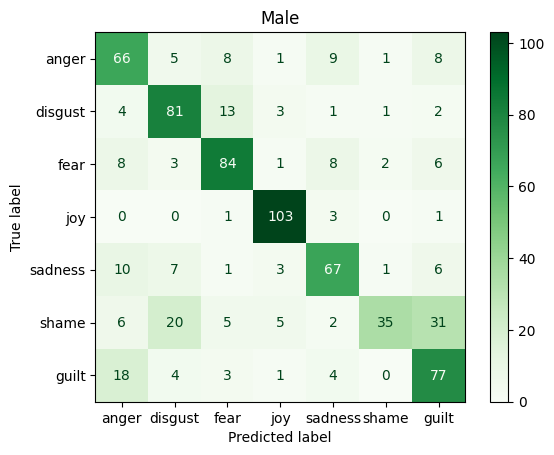

In [8]:
plot_confusion_matrix(male_merged_df, valid_emotions, 'Male', save_dir, plt.cm.Greens)

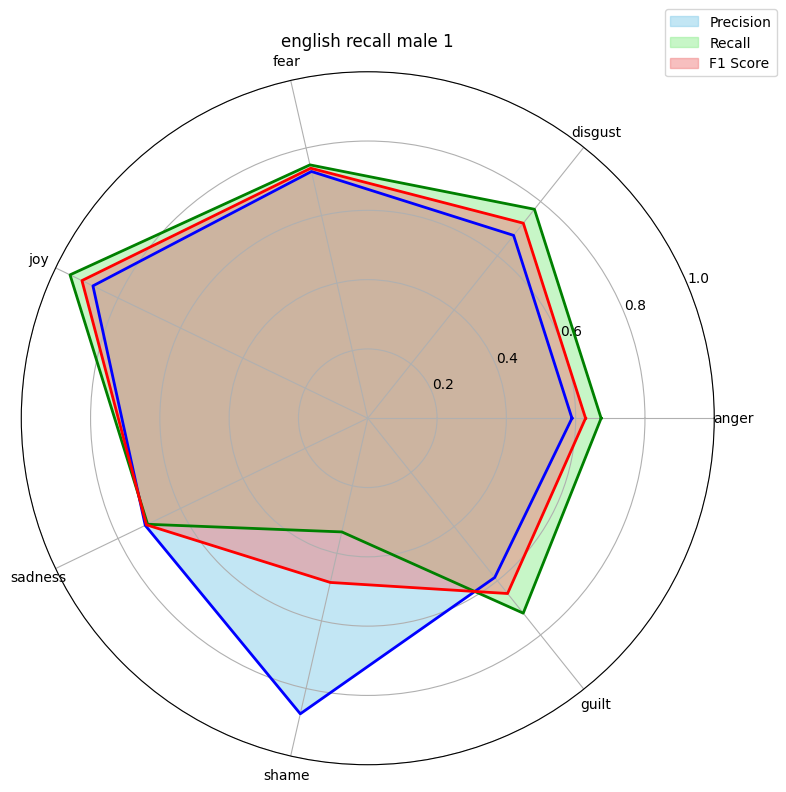

In [9]:
plot_spider_graph(male_metrics, output_male, output_dir)

In [10]:
female_merged_df = load_merge_data(gold_dir, gold_file, output_dir, output_female, valid_emotions, gender_target="Fl")
print(f"female_merged_df len : {female_merged_df.shape}")
female_metrics = calculate_metrics(female_merged_df, valid_emotions)
print("Female Metrics:\n", female_metrics)

Fl number : 216
female_merged_df len : (209, 13)
Female Metrics:
    Emotion  Precision    Recall  F1 Score
0    anger   0.692308  0.257143  0.375000
1  disgust   0.571429  0.750000  0.648649
2     fear   0.586207  0.680000  0.629630
3      joy   0.896552  0.896552  0.896552
4  sadness   0.581818  0.842105  0.688172
5    shame   1.000000  0.357143  0.526316
6    guilt   0.612903  0.863636  0.716981


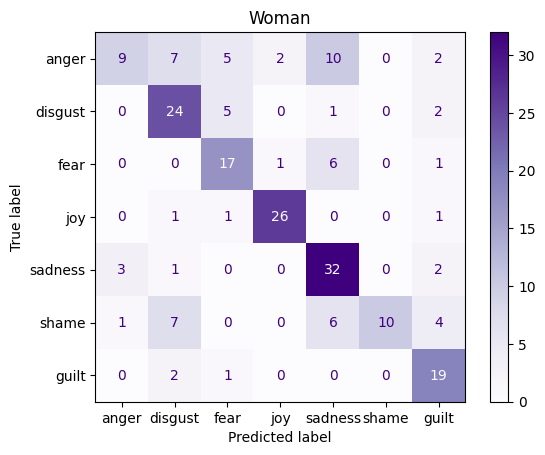

In [11]:
plot_confusion_matrix(female_merged_df, valid_emotions, 'Woman', output_dir, plt.cm.Purples)

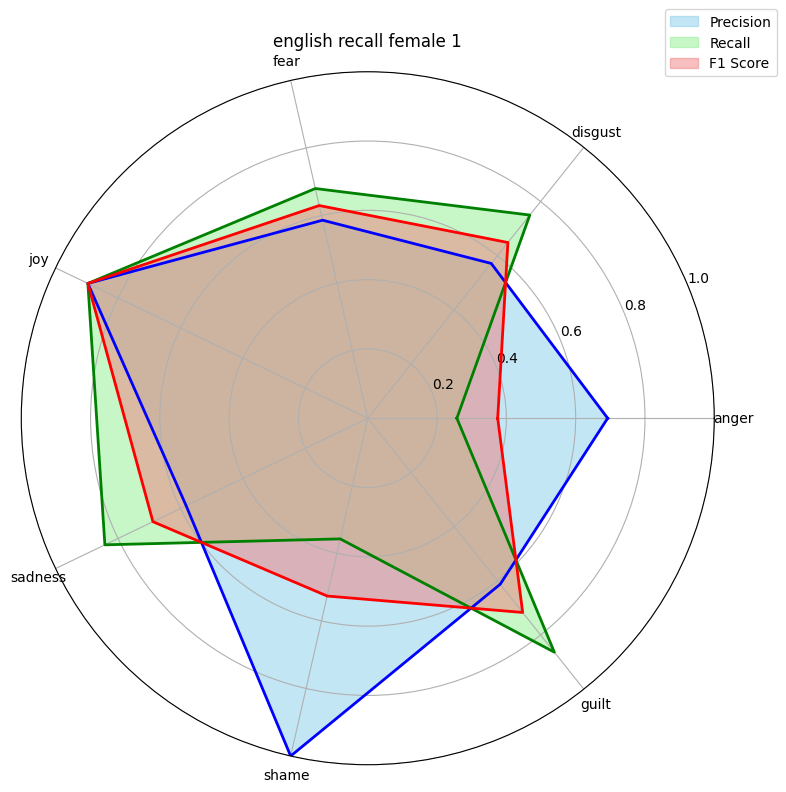

In [12]:
plot_spider_graph(female_metrics,output_female, output_dir)